## Annotation analisys (labelling)

This notebook is an attempt to compute dynamic statistics of the Superconductor dataset tags and labels.

In [146]:
import csv
import json
import os
import sys
from difflib import SequenceMatcher
from pathlib import Path
from sys import argv
import pysbd

from bs4 import BeautifulSoup, NavigableString, Tag
from grobid_tokenizer import tokenizeSimple

In [147]:
seg = pysbd.Segmenter(language="en")

def process_dir(input):
    # xdir = Path('/data/workspace/Suzuki/supercon_files_20190808/iop/data/')
    # xmlfiles = [x for x in xdir.glob('**/*.xml')]
    # pdffiles = [x for x in xdir.glob('**/*.pdf')]
    accumulated_statistics = []
    for root, dirs, files in os.walk(input):
        for file_ in files:
            if not file_.lower().endswith(".xml"):
                continue
            abs_path = os.path.join(root, file_)
#             print("Processing: " + str(abs_path))
            output_data = process_file(abs_path)
            accumulated_statistics.append(output_data)

    return accumulated_statistics


def process_file(input):
    with open(input, encoding='utf-8') as fp:
        doc = fp.read()

    soup = BeautifulSoup(doc, 'xml')

    entities_statistics = {}
    document_statistics = {
        'name': Path(input).name,
        'path': str(Path(input).absolute()),
        'paragraphs': 0,
        'sentences': 0,
        'tokens': 0,
        'entities': 0,
        'uniq_entities': 0,
        'classes': 0,
        'entities_statistics': entities_statistics
    }

    children = []
    for child in soup.tei.children:
        if child.name == 'teiHeader':
            children.append(child.find_all("title"))
            children.extend([subchild.find_all("p") for subchild in child.find_all("abstract")])
            children.append(child.find_all("ab", {"type": "keywords"}))
        elif child.name == 'text':
            children.append([subsubchild for subchild in child.find_all("body") for subsubchild in subchild.children if
                             type(subsubchild) is Tag])

    for child in children:
        for pTag in child:
            j = 0
            paragraphText = ''
            document_statistics['paragraphs'] += 1
            for item in pTag.contents:
                if type(item) == NavigableString:
                    paragraphText += str(item)

                elif type(item) is Tag and item.name == 'rs':
                    paragraphText += item.text
                    document_statistics['entities'] += 1
                    tag_content = item.text
                    paragraphText += str(item.text)
                    if 'type' not in item.attrs:
                        raise Exception("RS without type is invalid. Stopping")

                    tag_name = item.attrs['type']

                    if tag_name not in entities_statistics:
                        entities_statistics[tag_name] = {
                            'count': 1,
                            'content_distribution': {
                                tag_content: 1
                            }
                        }
                    else:
                        content_ = entities_statistics[tag_name]
                        content_['count'] += 1
                        if tag_content not in content_['content_distribution']:
                            content_['content_distribution'][tag_content] = 1
                        else:
                            content_['content_distribution'][tag_content] += 1

            document_statistics['tokens'] += len(tokenizeSimple(paragraphText))
            document_statistics['classes'] = len(set(entities_statistics.keys()))
            document_statistics['sentences'] += len(seg.segment(paragraphText))

    uniq_entities = 0
    for key in entities_statistics:
        uniq_entities += len(entities_statistics[key]['content_distribution'])

    document_statistics['uniq_entities'] = uniq_entities

    ## Cross checks

    # Verify that the sum of the content distribution corresponds to the tag distribution
    total_entities = 0
    for tag in entities_statistics:
        count = entities_statistics[tag]['count']
        sum_content_distributions = 0
        content_distribution_dict = entities_statistics[tag]['content_distribution']
        for content in content_distribution_dict:
            sum_content_distributions += content_distribution_dict[content]

        assert "Number of total entities per tag does not correspond to the sum.", count == sum_content_distributions
        total_entities += count

    assert "Number of total entities per documnent does not correspond to the sum.", total_entities == \
                                                                                     document_statistics['entities']

    return document_statistics


def group_by_with_soft_matching(input_list, threshold):
    matching = {}
    last_matching = -1

    for index_x, x in enumerate(input_list):
        unpacked = [y for x in matching for y in matching[x]]
        if x not in matching and x not in unpacked:
            matching[x] = []

            for index_y, y in enumerate(input_list[index_x + 1:]):
                if x == y:
                    continue

                if SequenceMatcher(None, x.lower(), y.lower()).ratio() > threshold:
                    matching[x].append(y)

        else:
            continue

    return matching


def aggregate(entities_statistics, threshold):
    """
    Aggregate the statistics by merging content belonging to the same entity:
     - variation of expressions (e.g. cuprates, cuprate, Cuprates, ...)
     - synonyms (e.g. 111, cuprates, ...)

    :param document_statistics:
    :param threshold:
    :return: an aggregated statistics for documents
    """

    agg = {}

    for tag in entities_statistics:
        if tag == 'tcValue' or tag == 'pressure':
            continue

        distribution = entities_statistics[tag]["content_distribution"]

        content_list = sorted(distribution.keys())
        # hash_list = []
        # for content in content_list:
        #     hash_value = content.lower().replace(" ", "")
        #     hash_list.append((hash_value, content))

        aggregated = group_by_with_soft_matching(content_list, threshold)

        agg[tag] = aggregated

        assert "Total number of element does not corresponds with the aggregated ones", len(content_list) == (
                len(agg.keys()) + len([y for x in aggregated for y in aggregated[x]]))

    return agg


def extract_csv(output_data):
    entity_statistics = output_data['entities_statistics']
    csv_rows = []
    for tag in entity_statistics:
        for content in entity_statistics[tag]['content_distribution']:
            row = [tag, content, entity_statistics[tag]['content_distribution'][content]]
            csv_rows.append(row)

    return csv_rows


def intersection(lst1, lst2):
    # Use of hybrid method
    temp = set(lst2)
    lst3 = [value for value in lst1 if value in temp]
    return lst3


def extract_inconsistencies(output_data):
    entity_statistics = output_data['entities_statistics']
    summary_content = {}
    for tag in entity_statistics:
        for content in entity_statistics[tag]['content_distribution']:
            if tag in summary_content:
                summary_content[tag].append(content)
            else:
                summary_content[tag] = [content]

    inconsistencies = []

    tags = list(summary_content.keys())
    for id1 in range(0, len(tags)):
        for id2 in range(id1 + 1, len(tags)):
            tag1 = tags[id1]
            tag2 = tags[id2]

            tag1_content = summary_content[tag1]
            tag2_content = summary_content[tag2]

            intersected_content = intersection(tag1_content, tag2_content)

            if len(intersected_content) > 0:
                for intersected_content_ in intersected_content:
                    frequency1 = entity_statistics[tag1]['content_distribution'][intersected_content_]
                    frequency2 = entity_statistics[tag2]['content_distribution'][intersected_content_]
                    intersected_tags = [(tag1, frequency1), (tag2, frequency2)]
                    inconsistencies.append([intersected_content_, tag1, frequency1, tag2, frequency2])

    return inconsistencies

def find_longest_entities(output_data, topValues=10): 
    print(output_data)


Analysis 

In [148]:
def run_analysis(input): 
    output_data = {}

    input_path = Path(input)
    documents_statistics = process_dir(input_path)

    aggregated_entities_statistics = {}
    output_data = {
        'path': str(Path(input_path).absolute()),
        'files': len(documents_statistics),
        'paragraphs': 0,
        'sentences': 0,
        'tokens': 0,
        'entities': 0,
        'uniq_entities': 0,
        'classes': 0,
        'entities_statistics': aggregated_entities_statistics
    }

    classes = []

    ## Summary of all articles

    for document_statistics in documents_statistics:
        output_data['paragraphs'] += document_statistics['paragraphs']
        output_data['sentences'] += document_statistics['sentences']
        output_data['tokens'] += document_statistics['tokens']
        output_data['entities'] += document_statistics['entities']
        output_data['uniq_entities'] += document_statistics['uniq_entities']

        for tag in document_statistics['entities_statistics']:
            classes.append(tag)
            tag_statistics = document_statistics['entities_statistics'][tag]
            if tag not in aggregated_entities_statistics:
                aggregated_entities_statistics[tag] = tag_statistics
            else:
                count = tag_statistics['count']
                aggregated_entities_statistics[tag]['count'] += count

                dist = tag_statistics['content_distribution']
                aggregated_distribution = aggregated_entities_statistics[tag]['content_distribution']

                for content in dist:
                    if content not in aggregated_distribution:
                        aggregated_distribution[content] = dist[content]
                    else:
                        aggregated_distribution[content] += dist[content]

        output_data['classes'] = len(set(classes))

    output_data['documents'] = documents_statistics
    output_data['aggregated_statistics'] = aggregate(aggregated_entities_statistics, 0.90)
    output_data["inconsistencies"] = extract_inconsistencies(output_data)
    
    #find_longest_entities(output_data)

    return output_data 

Run Analysis 

In [149]:
input = "../corpus/final"
    
result = run_analysis(input)    

Extract summary on class repartition by frequency

In [150]:
columns=['files', 'paragraphs', 'sentences', 'tokens', 'entities', 'uniq_entities', 'classes']
rows = [result[c] for c in columns]

import pandas as pd
pd.DataFrame([rows], columns=columns)

,files,paragraphs,sentences,tokens,entities,uniq_entities,classes
0,142,3505,18342,1118483,16040,7151,6


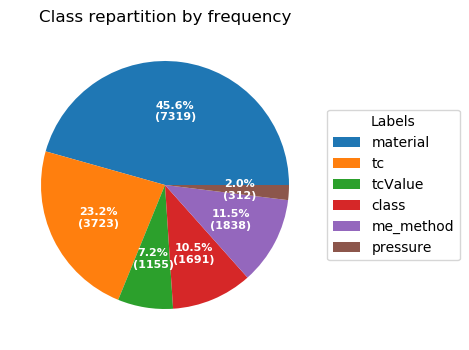

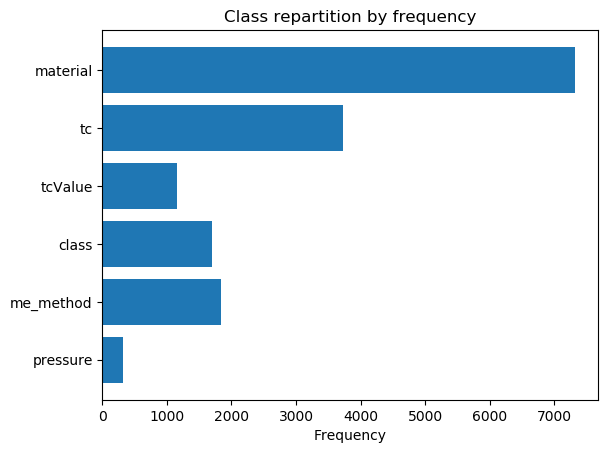

In [151]:
import json

aggregated_statistics = result['aggregated_statistics']
entities_statistics = result['entities_statistics']

# print(json.dumps(entities_statistics, indent=4))

labels = []
values = []

for label in entities_statistics.keys(): 
    labels.append(label)
    values.append(entities_statistics[label]['count'])

    
## PIE
import matplotlib.pyplot as plt
import numpy as np

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)
    

fig, ax = plt.subplots(figsize=(4, 8), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(values, autopct=lambda pct: func(pct, values),
                                  textprops=dict(color="w"))


ax.legend(wedges, labels,
          title="Labels",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")
ax.set_title("Class repartition by frequency")
plt.show()

## HISTOGRAM

plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(labels, values, align='center')
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Frequency')
ax.set_title('Class repartition by frequency')

plt.show()

#csv_row = extract_csv(output_data)


# Inconsistencies 

In the following section we show annotations that have been annotated in different ways. 
For example if a certain name "xyz" has been annotated twice with two different annotations, it is listed under here. 


This doesn't means necessarly it's an error. We can conclude that the inconsistency tc-material can be attributed to mistakes, while material-class is due to ambiguities and overlapping in the definition of both labels where the outcome depends strongly from the context. 

In [152]:
inconsistent_classes = result["inconsistencies"]

# print(inconsistent_classes)

rows = inconsistent_classes
columns=['name', 'class 1', 'frequency', 'class 2', 'frequency']
    
import pandas as pd
pd.DataFrame(rows, columns=columns)

,name,class 1,frequency,class 2,frequency
0,Bi-2212,material,46,class,1
1,sulfur hydride,material,11,class,10
2,AOs 2 O 6,material,9,class,1
3,La-2125,material,6,class,2
4,cobalt oxide,material,3,class,4
5,Ru-1212,material,10,class,4
6,Hg-1212,material,2,class,2
7,Y-123,material,35,class,3
8,Cu,material,4,class,1
9,LnOFeAs,material,14,class,3


The following code identifies content in entities that it's length is more than 400% the average length of the content for each class. 

In [153]:
import pprint
# pprint.PrettyPrinter().pprint(result['entities_statistics'])

for label, value in result['entities_statistics'].items(): 
    print(label)
    average = 0
    total = 0
    for content, count in result['entities_statistics'][label]['content_distribution'].items(): 
        average += len(content)
        total +=1
    
    average = average / total
    for content, count in result['entities_statistics'][label]['content_distribution'].items(): 
        if((len(content) / average) * 100) > 400:
            print(content)
            
    print("")
    
    

material
(1-x/2)La 2 O 3 /xSrCO 3 /CuO in molar ratio with x = 0.063, 0.07, 0.09, 0.10, 0.111 and 0.125
La 2-x Sr x CuO 4 thin films with Sr content x = 0.045, 0.050, 0.055, 0.060, 0.100, 0.200, 0.250 and 0.270
La 2−x Ce x CuO 4−δ (LCCO) and Pr 2−x Ce x CuO 4−δ (PCCO) films grown directly on SrTiO 3 substrates
Pr 0.5 Ca 0.5 Ba 2 Cu 3 O 7−δ thin films grown on the substrates of SrTiO 3 and Yttrium-stabilized ZrO 2
LnOFeAs oxyarsenides of the majority of light rare-earth metals Ln Ce, Pr, Nd, Sm, Gd, Tb, and Dy
Sr x K 1Àx Fe 2 As 2 crystal structure for a series of samples with x 0, 0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, and 1.0
REBa 2 Cu 3 O 7-δ ("RBCO", "RE-123") where RE can be La or any rare earth element except for Ce or Tb
ultrathin Bi2212 single crystal has more than 8 (CuO 2 ) 2 -layers (12 nm or 4 unit cells thick)
Electron-doped infinite-layer superconductors (Sr +2 1−x Ln +3 x )CuO 2 (Ln = La, Sm, Nd, Gd, etc.)
electron-doped infinite- layer superconductors Sr 0.9 La 0.1 Cu 1−x R 

# Label summary

In this section we analise each label and we output 
 - top terms 
 - the aggregation of similar terms using soft-matching

In [154]:
def plot_top_10(label, statistics): 
    class_statistics = statistics[label]
    class_count = class_statistics['count']
    print("count: " + str(class_count))
    class_frequency = class_statistics['content_distribution']
           
    sorted_by_value = {k: v for k, v in sorted(class_frequency.items(), key=lambda item: item[1], reverse=True)}

    top_10 = {k:sorted_by_value[k] for k in list(sorted_by_value.keys())[0:10]}
    # print(json.dumps(top_10, indent=4))

    ## HISTOGRAM

    plt.rcdefaults()
    fig, ax = plt.subplots()

    items = list(top_10.values())
    keys = list(top_10.keys())

    ax.barh(keys, items , align='center')
    ax.set_yticklabels(keys)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Frequency')
    ax.set_title(label +' annotation values top terms')

    plt.show()

    
def aggregate_by_soft_matching(statistics, aggregated):

#     agg_statistics_soft_matching = aggregated[label]
#     print(json.dumps(agg_statistics_soft_matching, indent=4))

    delete = []
    for k, v in aggregated.items(): 
        if len(v) > 0: 
            for val in v:
                
                statistics[k] += statistics[val]
                statistics[val] = 0
                delete.append(val)

    # print(json.dumps(stat, indent=4))
    print("Aggregating " + str(len(delete)) + " elements")
    
    return statistics    

## Class

the label `<class> `


Aggregating 132 elements
count: 1692


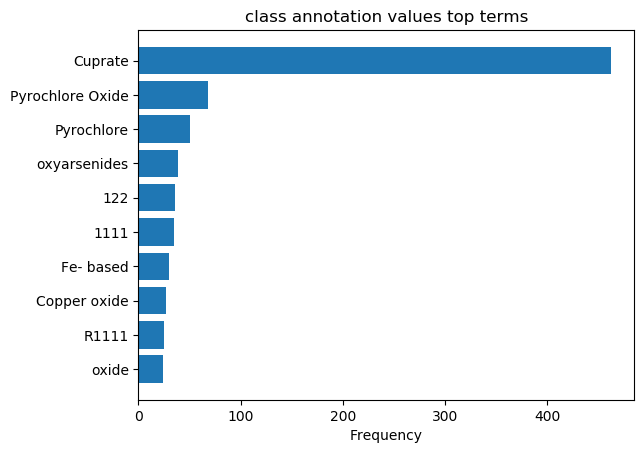

In [155]:
import copy 
entities_statistics = copy.copy(result['entities_statistics'])
# print(json.dumps(entities_statistics['class'], indent=4))
# plot_top_10('class', entities_statistics)

content_distribution = entities_statistics["class"]['content_distribution']
aggregated_statistics = result['aggregated_statistics']["class"]
entities_statistics["class"]['content_distribution'] = aggregate_by_soft_matching(content_distribution, aggregated_statistics)

## TODO update count

# Aggregated statistics via soft-matching
# print(json.dumps(result, indent=4))

# with open("bao.json", 'w') as f:
#     json.dump(result, f, indent=4)

# print(json.dumps(entities_statistics["class"]['content_distribution'], indent=4))
plot_top_10("class", entities_statistics)

#print(json.dumps(entities_statistics["class"], indent=4))
# agg_statistics_soft_matching_inv_map = {v: k for k, v in agg_statistics_soft_matching.items()}
# print(json.dumps(agg_statistics_soft_matching_inv_map, indent=4))

## Material

the label `<material> `

Aggregating 579 elements
count: 7319


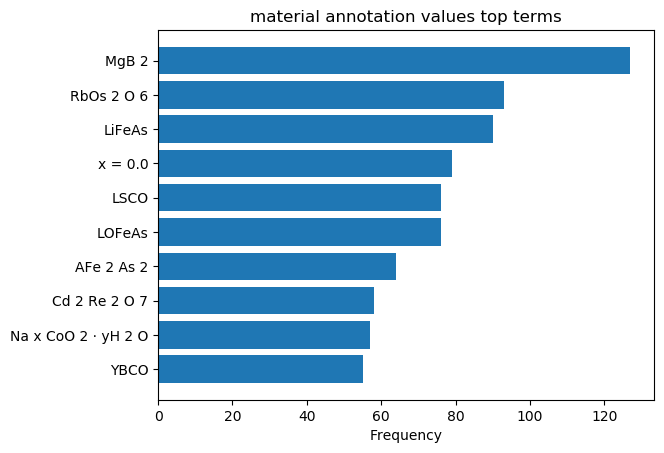

In [156]:
import copy
entities_statistics = copy.copy(result['entities_statistics'])

aggregated_statistics = result['aggregated_statistics']['material']
content_distribution = entities_statistics["material"]['content_distribution']
entities_statistics["material"]['content_distribution'] = aggregate_by_soft_matching(content_distribution, aggregated_statistics)

plot_top_10("material", entities_statistics)

## Class (from Materials) distribution

In [157]:
import copy
entities_statistics = copy.copy(result['entities_statistics'])

aggregated_statistics = result['aggregated_statistics']['material']
content_distribution = entities_statistics["material"]['content_distribution']
entities_statistics["material"]['content_distribution'] = aggregate_by_soft_matching(content_distribution, aggregated_statistics)
entities_statistics["material"]['content_distribution']
# plot_top_10("material", entities_statistics)

Aggregating 579 elements


{'Under-doped La 2−x Sr x CuO 4 with x = 0.063 -0.125': 1,
 'La2−xSrxCuO4 (LSCO)': 2,
 'x = 0.063, 0.07, 0.09, 0.10, 0.111 and 0.125': 1,
 'x = 1/4 2 (=0.0625) and 1/3 2 (=0.111)': 1,
 'La 2−x Sr x CuO 4 (LSCO)': 0,
 'LSCO': 76,
 'x < 0.02': 1,
 'La 2−x Sr x CuO 4': 0,
 '0.02 < x < 0.05': 1,
 '0.05 < x < 0.26)': 1,
 '0.26 < x < 0.6': 1,
 'x > 0.6': 2,
 'x = 0.15': 0,
 'La 2−x Sr x CuO 4 single crystals': 0,
 'x = 0.063 -0.125': 2,
 '(1-x/2)La 2 O 3 /xSrCO 3 /CuO in molar ratio with x = 0.063, 0.07, 0.09, 0.10, 0.111 and 0.125': 1,
 'La 2 CuO 4': 27,
 'La 1.875 Sr 0.125 CuO 4 crystal': 1,
 'La 1.91 Sr 0.09 CuO 4 (x = 0.09)': 1,
 'LSCO crystals': 0,
 'La 1.91 Sr 0.09 CuO 4(x = 0.09) crystal': 0,
 'x = 0.063': 2,
 'x = 0.125': 11,
 'x = 1/4 2 (=0.0625)': 1,
 '1/3 2 (=0.111)': 1,
 'x = 1/3 2': 2,
 'La 1.91 Sr 0.09 CuO 4 (x = 0.09) crystal': 2,
 'x = 0.09 LSCO crystal': 1,
 'La 1.91 Sr 0.09 CuO 4': 2,
 'La 2−x Sr x CuO 4 single crystals with various doping levels (x = 0.063 -0.125)': 1,
 'S

## Critical temperature expressions

the label `<tc>`

count: 3723


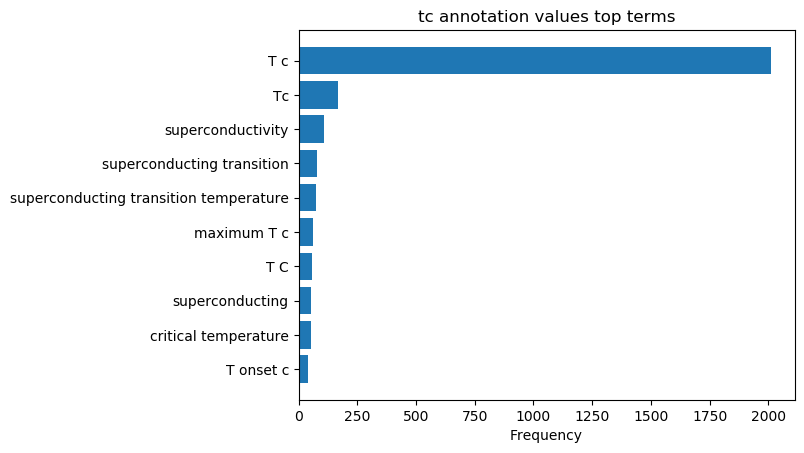

In [158]:
import copy
entities_statistics = copy.copy(result['entities_statistics'])

aggregated_statistics = result['aggregated_statistics']['tc']
content_distribution = entities_statistics["tc"]['content_distribution']
#entities_statistics["tc"]['content_distribution'] = aggregate_by_soft_matching(content_distribution, aggregated_statistics)

plot_top_10("tc", entities_statistics)

## Measurement Methods

the label `<me_methods>`

Aggregating 125 elements
count: 1838


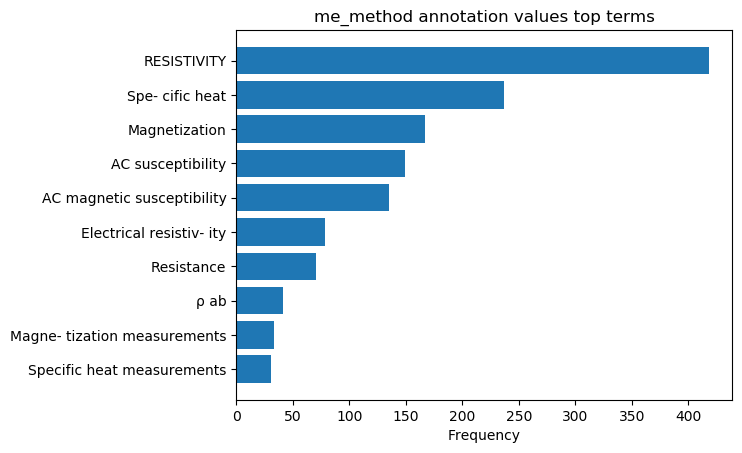

In [159]:
import copy
entities_statistics = copy.copy(result['entities_statistics'])

name = 'me_method'
aggregated_statistics = result['aggregated_statistics'][name]
content_distribution = entities_statistics[name]['content_distribution']
entities_statistics[name]['content_distribution'] = aggregate_by_soft_matching(content_distribution, aggregated_statistics)

plot_top_10(name, entities_statistics)


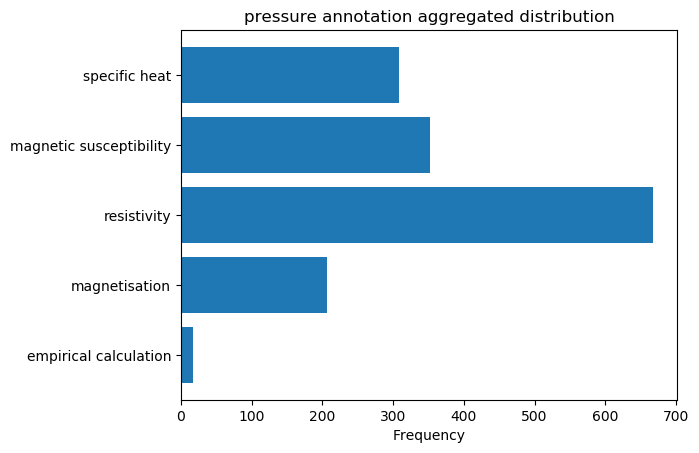

Not assigned to any class: 
['SQUID magnetometer', 'Magne- tization measurements', 'specific', 'magnetotransport measurement', 'susceptibil- ity', 'resis- tivity', 'resistive transi- tion', 'suscepti- bility', 'χ', 'transport measurements', 'mag- netization measurements', 'magne- tization', 'sus- ceptibility', 'suscept- ibility', 'suscep- tibility measurements', 'Zero-field measurements', 'transport', 'y < 6.60', 'resistiv- ity', 'standard four-probe technique', 'R', 'R − T curve', 'R-T curve', 'ρ', 're- sistivity', 'Eliashberg equation', 'experimental', 'estimated in the Eliashberg model', 'conductance', 'approximation', 'resistitively', 'resistively', 'ρ(T)', 'χAC (T ) experiments', 'suscep- tibility', 'in-plane resis- tivity', 'mag- netization', 'resistiv- ity measurements', 'midpoint of the super- conducting transition', 'zero-field-cooled (ZFC)', 'resistive transition', 'C', 'ρc', 'ρ ab', 'ρ c', 'ρ(T ) measurements', 'ρ(T )', 'C(T )', 'R-T curves', 'R-T', 'M-T', 'M-T curve', 'M-T 

In [160]:
local_distribution = copy.copy(entities_statistics[name]['content_distribution'])

classes = {
    "specific heat": {
        "total":0, 
        "values": [],
        "names": ["heat", "therm"]
    }, 
    "magnetic susceptibility": {
        "total":0, 
        "values": [],
        "names": ["susceptibilit"]
    }, 
    "resistivity": {
        "total":0, 
        "values": [],
        "names": ["resistivit", "resistance", "electrical"]        
    },
    "magnetisation": {
        "total":0, 
        "values": [],
        "names": ["magneti"]        
    },
    "empirical calculation": {
        "total":0, 
        "values": [],
        "names": ["calcula", "predict", "theor"]        
    }
    
}

not_assigned = []
assigned = False
for key in local_distribution.keys(): 
    for key_class, value in classes.items():
        for names in value['names']: 
            if names in str.lower(key): 
                classes[key_class]["values"].append(key_class)
                classes[key_class]["total"] += local_distribution[key]
                assigned = True
                break
        if assigned:
            break
        
                
    if assigned == False: 
        not_assigned.append(key)
    else: 
        assigned = False
            
            

## HISTOGRAM

plt.rcdefaults()
fig, ax = plt.subplots()

items = [classes[c]["total"] for c in classes]
keys = list(classes.keys())

ax.barh(keys, items , align='center')
ax.set_yticklabels(keys)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Frequency')
ax.set_title(label +' annotation aggregated distribution')

plt.show()

print("Not assigned to any class: ")            
print(not_assigned)

## Pressure

the label `<pressure>`

count: 313


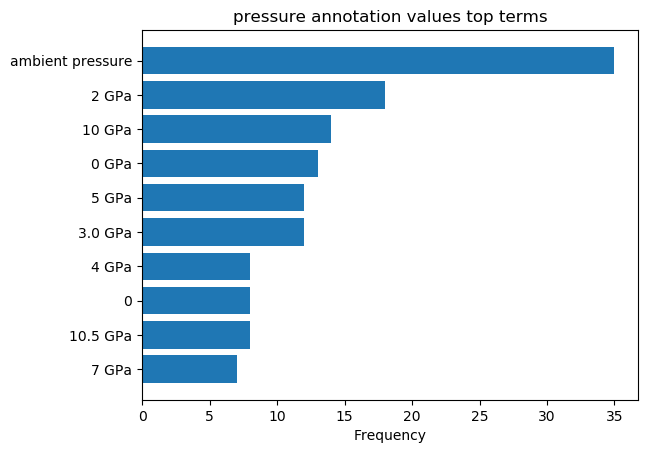

In [161]:
entities_statistics = result['entities_statistics']
plot_top_10('pressure', entities_statistics)

## Critical temperature value 

the label `<tcValue>`

count: 1155


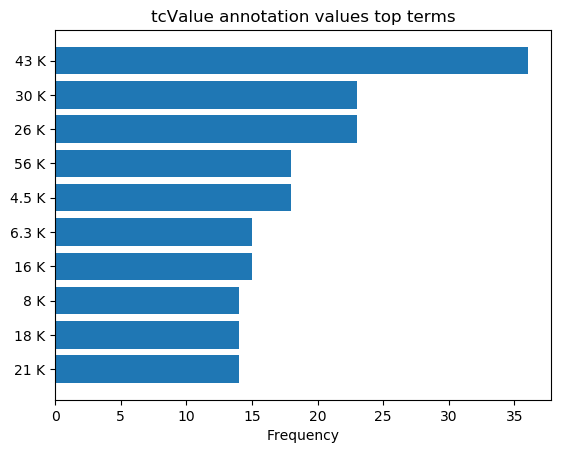

In [162]:
entities_statistics = result['entities_statistics']
plot_top_10('tcValue', entities_statistics)